# Explicación `transformación cíclica`

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Enero de 2026  
**Versión:** 1.0

---

## Descripción

Este notebook contiene la explicación de la `transformación cíclica`

Es una tarea común en lo que se conoce como `feature engineering` cuando se trabaja con variables de tiempo, dado que va a interesar medid *cercanía*.


---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```python
import pandas as pd
print(pd.__version__)
````

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [13]:
np.random.seed(29)

n = 1000

data = pd.DataFrame({
    "hour": np.random.randint(0, 24, size=n),
    "month": np.random.randint(1, 13, size=n)
})

data.head()

,hour,month
0,21,8
1,19,5
2,12,2
3,2,3
4,8,7


# Explicación matemática - geométrica

$x_{sin}=\sin(\frac{2\pi*x}{P})$

$x_{cos}=\cos(\frac{2\pi*x}{P})$

In [14]:
# Aplica la transformación cíclica
data_x = data.copy()
data_x["hour_sin"] = np.sin(2 * np.pi * data_x["hour"] / 24)
data_x["hour_cos"] = np.cos(2 * np.pi * data_x["hour"] / 24)

# month - 1 para que enero empiece en 0
data_x["month_sin"] = np.sin(2 * np.pi * (data_x["month"] - 1) / 12)
data_x["month_cos"] = np.cos(2 * np.pi * (data_x["month"] - 1) / 12)

In [15]:
data_x.head()

,hour,month,hour_sin,hour_cos,month_sin,month_cos
0,21,8,-7.071068e-01,0.707107,-5.000000e-01,-0.866025
1,19,5,-9.659258e-01,0.258819,8.660254e-01,-0.500000
2,12,2,1.224647e-16,-1.000000,5.000000e-01,0.866025
3,2,3,5.000000e-01,0.866025,8.660254e-01,0.500000
4,8,7,8.660254e-01,-0.500000,1.224647e-16,-1.000000


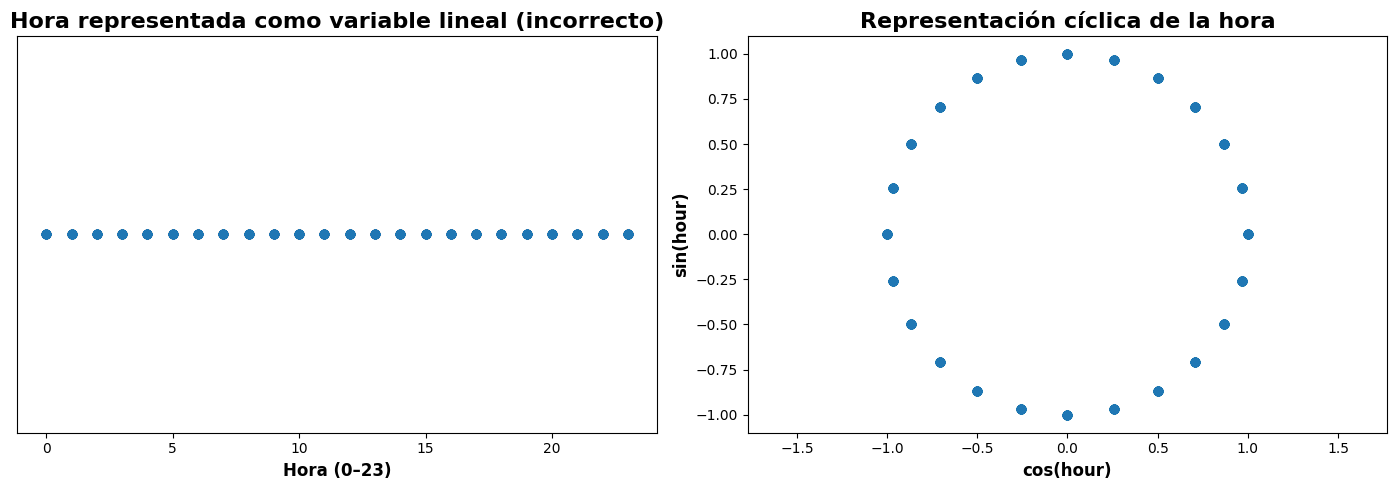

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Izquierda: SIN transformación
axes[0].scatter(
    data_x["hour"],
    np.zeros_like(data_x["hour"]),
    alpha=0.3
)
axes[0].set_yticks([])
axes[0].set_xlabel("Hora (0–23)", fontsize=12, fontweight="bold")
axes[0].set_title(
    "Hora representada como variable lineal (incorrecto)",
    fontsize=16,
    fontweight="bold"
)

# Derecha: CON transformación
axes[1].scatter(
    data_x["hour_cos"],
    data_x["hour_sin"],
    alpha=0.5
)
axes[1].set_title(
    "Representación cíclica de la hora",
    fontsize=16,
    fontweight="bold"
)
axes[1].set_xlabel("cos(hour)", fontsize=12, fontweight="bold")
axes[1].set_ylabel("sin(hour)", fontsize=12, fontweight="bold")
axes[1].axis("equal")

plt.tight_layout()
plt.show()


## Calcula distancia `cíclica` entre las 23:00 y las 00:00

In [17]:
row_23 = data_x[data_x["hour"] == 23].iloc[0]
row_0 = data_x[data_x["hour"] == 0].iloc[0]

p_23 = np.array([row_23["hour_sin"], row_23["hour_cos"]])
p_0 = np.array([row_0["hour_sin"], row_0["hour_cos"]])

dist_hour_23_0 = np.linalg.norm(p_23 - p_0)
dist_hour_23_0

np.float64(0.261052384440104)

## Calcula distancia `cíclica` entre las 12:00 y las 00:00 (horas opuestas)

In [18]:
row_12 = data_x[data_x["hour"] == 12].iloc[0]
p_12 = np.array([row_12["hour_sin"], row_12["hour_cos"]])

dist_hour_0_12 = np.linalg.norm(p_0 - p_12)
dist_hour_0_12

np.float64(2.0)

## Calcula distancia `cíclica` entre Diciembre y Enero

In [26]:
row_12m = data_x[data_x["month"] == 12].iloc[0]
row_1m = data_x[data_x["month"] == 1].iloc[0]

p_12m = np.array([row_12m["month_sin"], row_12m["month_cos"]])
p_1m = np.array([row_1m["month_sin"], row_1m["month_cos"]])

dist_month_12_1 = np.linalg.norm(p_12m - p_1m)
dist_month_12_1


np.float64(0.517638090205042)

## Calcula distancia `cíclica` entre Julio y Enero (meses opuestos)

In [27]:
row_7m = data_x[data_x["month"] == 7].iloc[0]

p_7m = np.array([row_7m["month_sin"], row_7m["month_cos"]])

dist_month_1_7 = np.linalg.norm(p_1m - p_7m)
dist_month_1_7


np.float64(2.0)

# Aplicación de la transformación

In [7]:
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, max_value):
        self.max_value = max_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Acá aplica la fórmula ya explicada
        sin = np.sin(2 * np.pi * X / self.max_value)
        cos = np.cos(2 * np.pi * X / self.max_value)
        return np.c_[sin, cos]

In [8]:
cyclical_features = ColumnTransformer(
    transformers=[
        ("hour", CyclicalFeatures(24), ["hour"]),
        ("month", CyclicalFeatures(12), ["month"])
    ],
    remainder="drop"
)

In [9]:
time_pipeline = Pipeline(steps=[
    ("cyclical", cyclical_features),
    ("scaler", StandardScaler())
])

In [10]:
X_time = time_pipeline.fit_transform(data)
X_time.shape

(1000, 4)

In [11]:
columns_name = [
    "hour_sin", "hour_cos",
    "month_sin", "month_cos"
]

data_time = pd.DataFrame(X_time, columns=columns_name)
data_time.head()


,hour_sin,hour_cos,month_sin,month_cos
0,-1.026455,0.968739,-1.196502,-0.713205
1,-1.397263,0.342570,0.746283,-1.228297
2,-0.013388,-1.415751,1.266850,0.694055
3,0.702958,1.190717,1.457391,-0.009575
4,1.227359,-0.717350,-0.675934,-1.228297


# Comentarios

+ La transformación cíclica convierte una variable temporal en una representación geométrica continua, permitiendo que el modelo aprenda correctamente la cercanía entre eventos temporales.

+ Al transformar variables cíclicas, es posible medir correctamente la cercanía temporal usando distancia euclidiana, algo imposible con la representación lineal original.